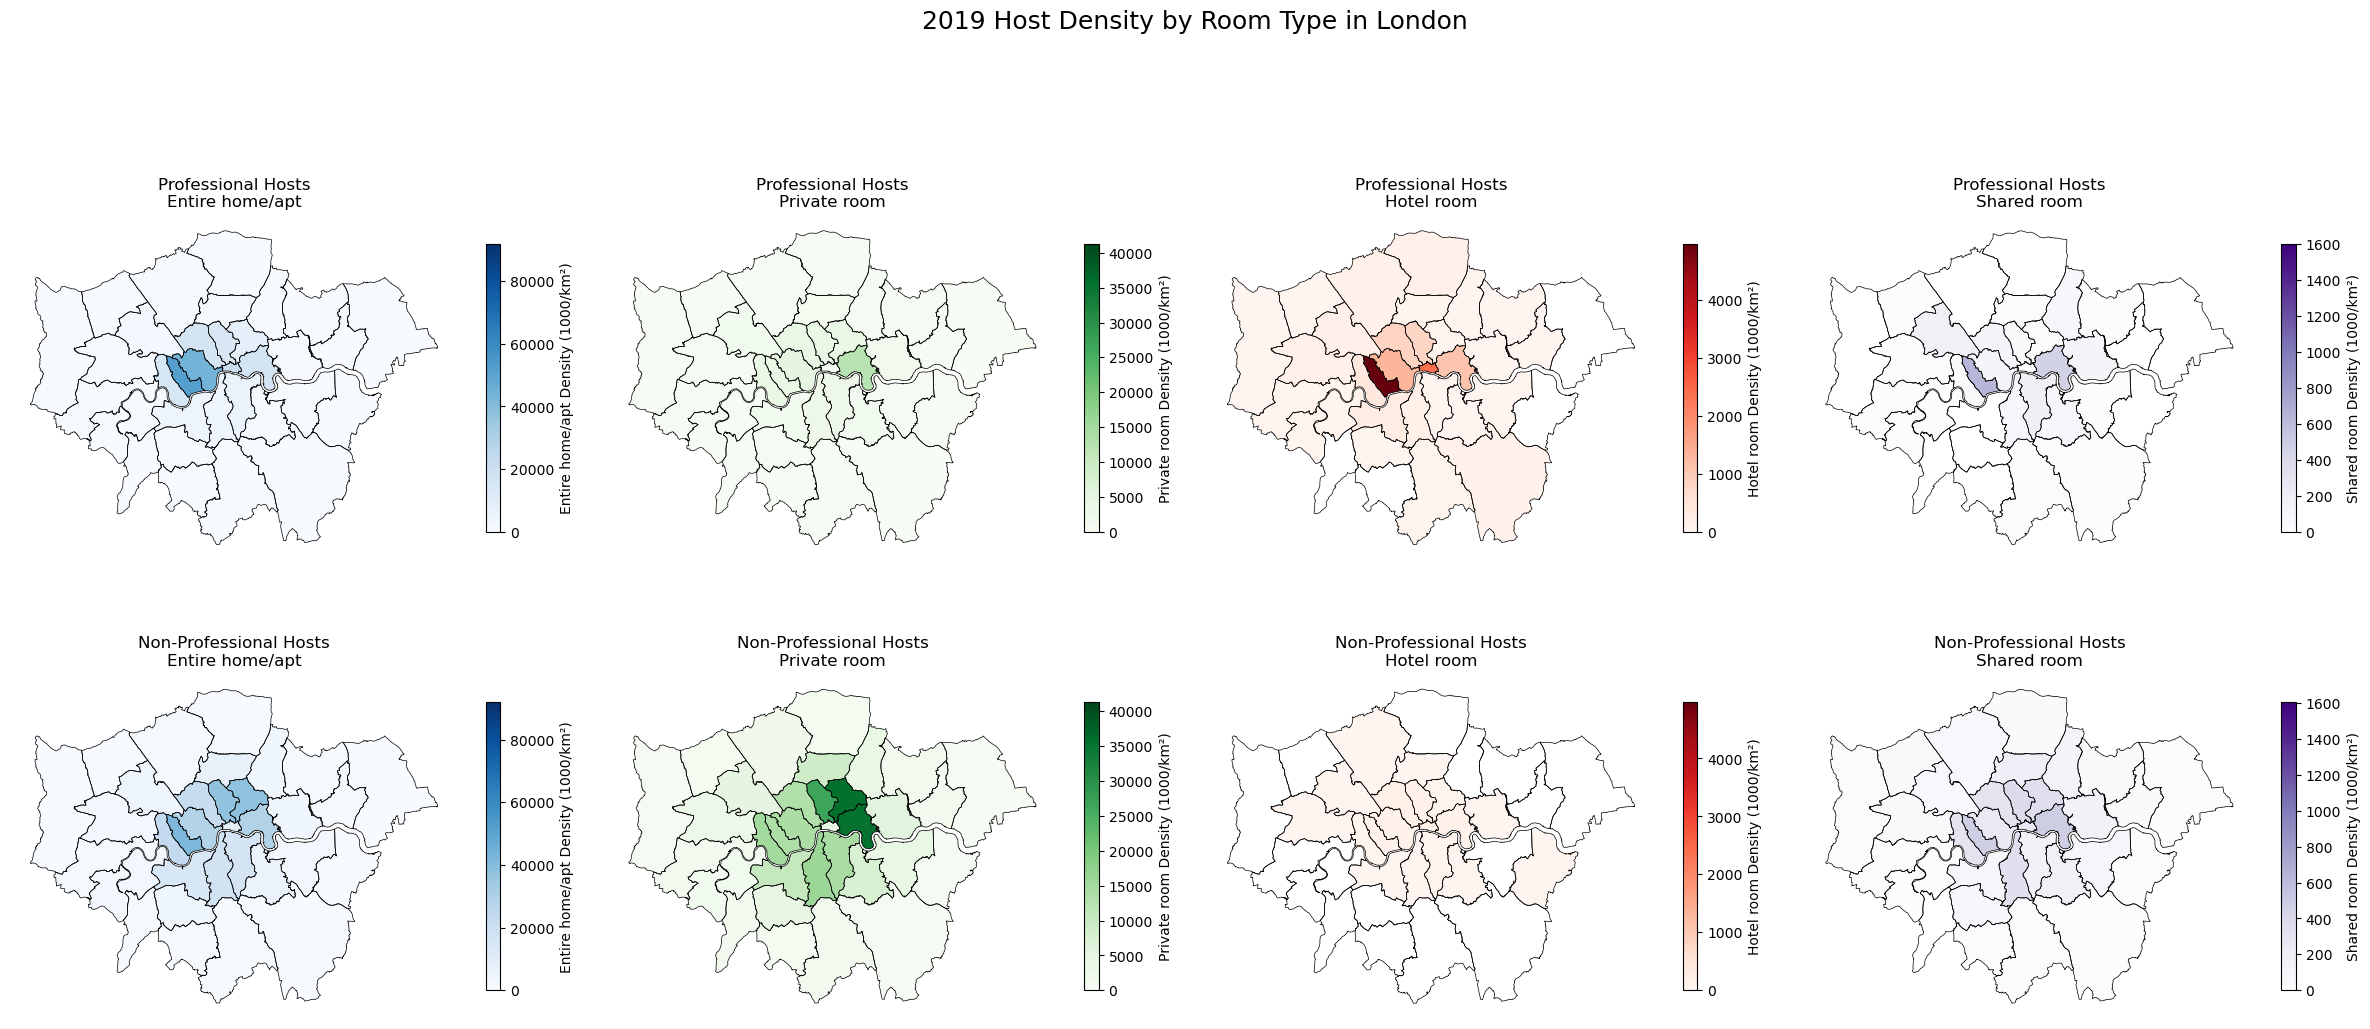

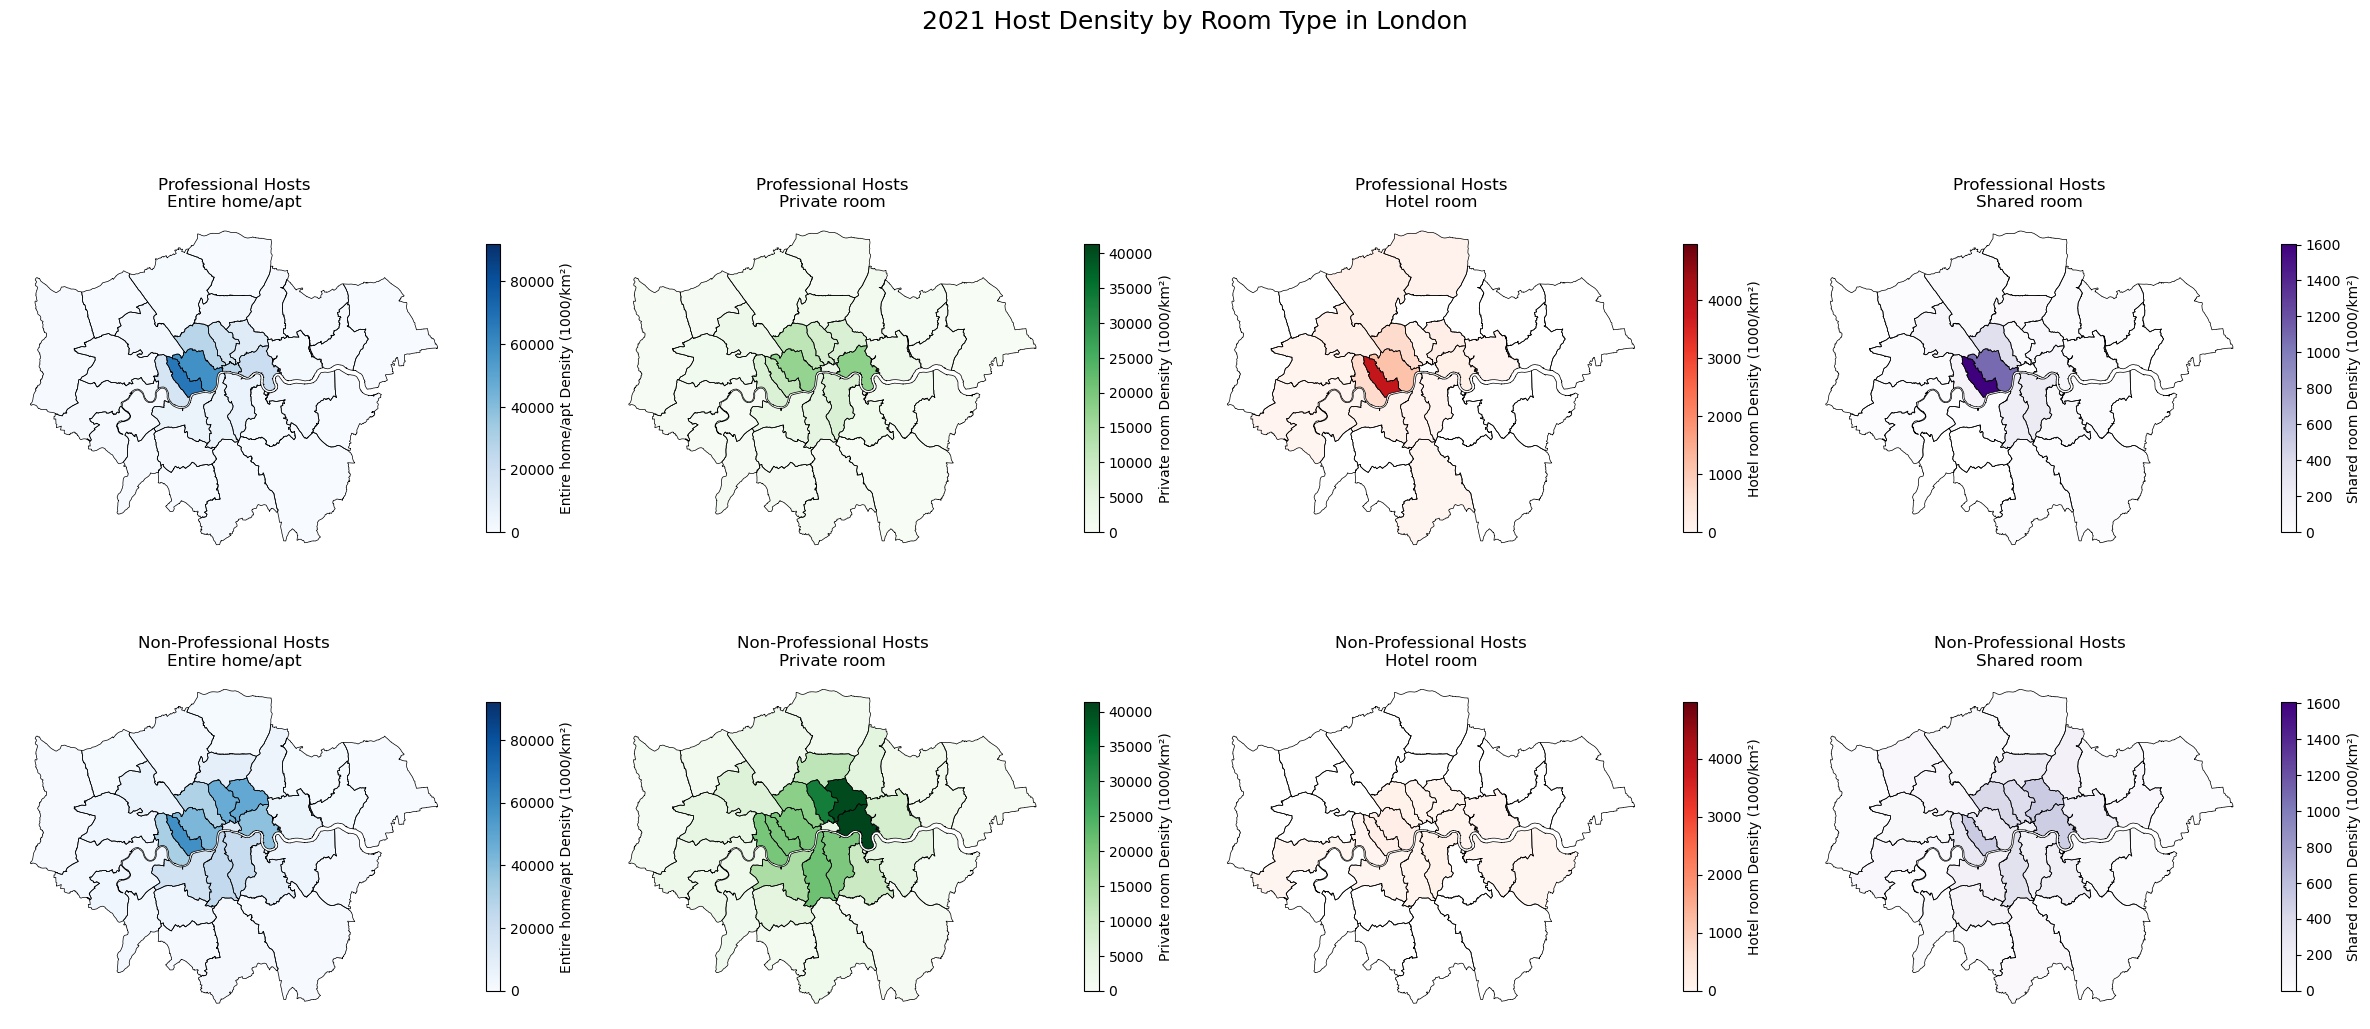

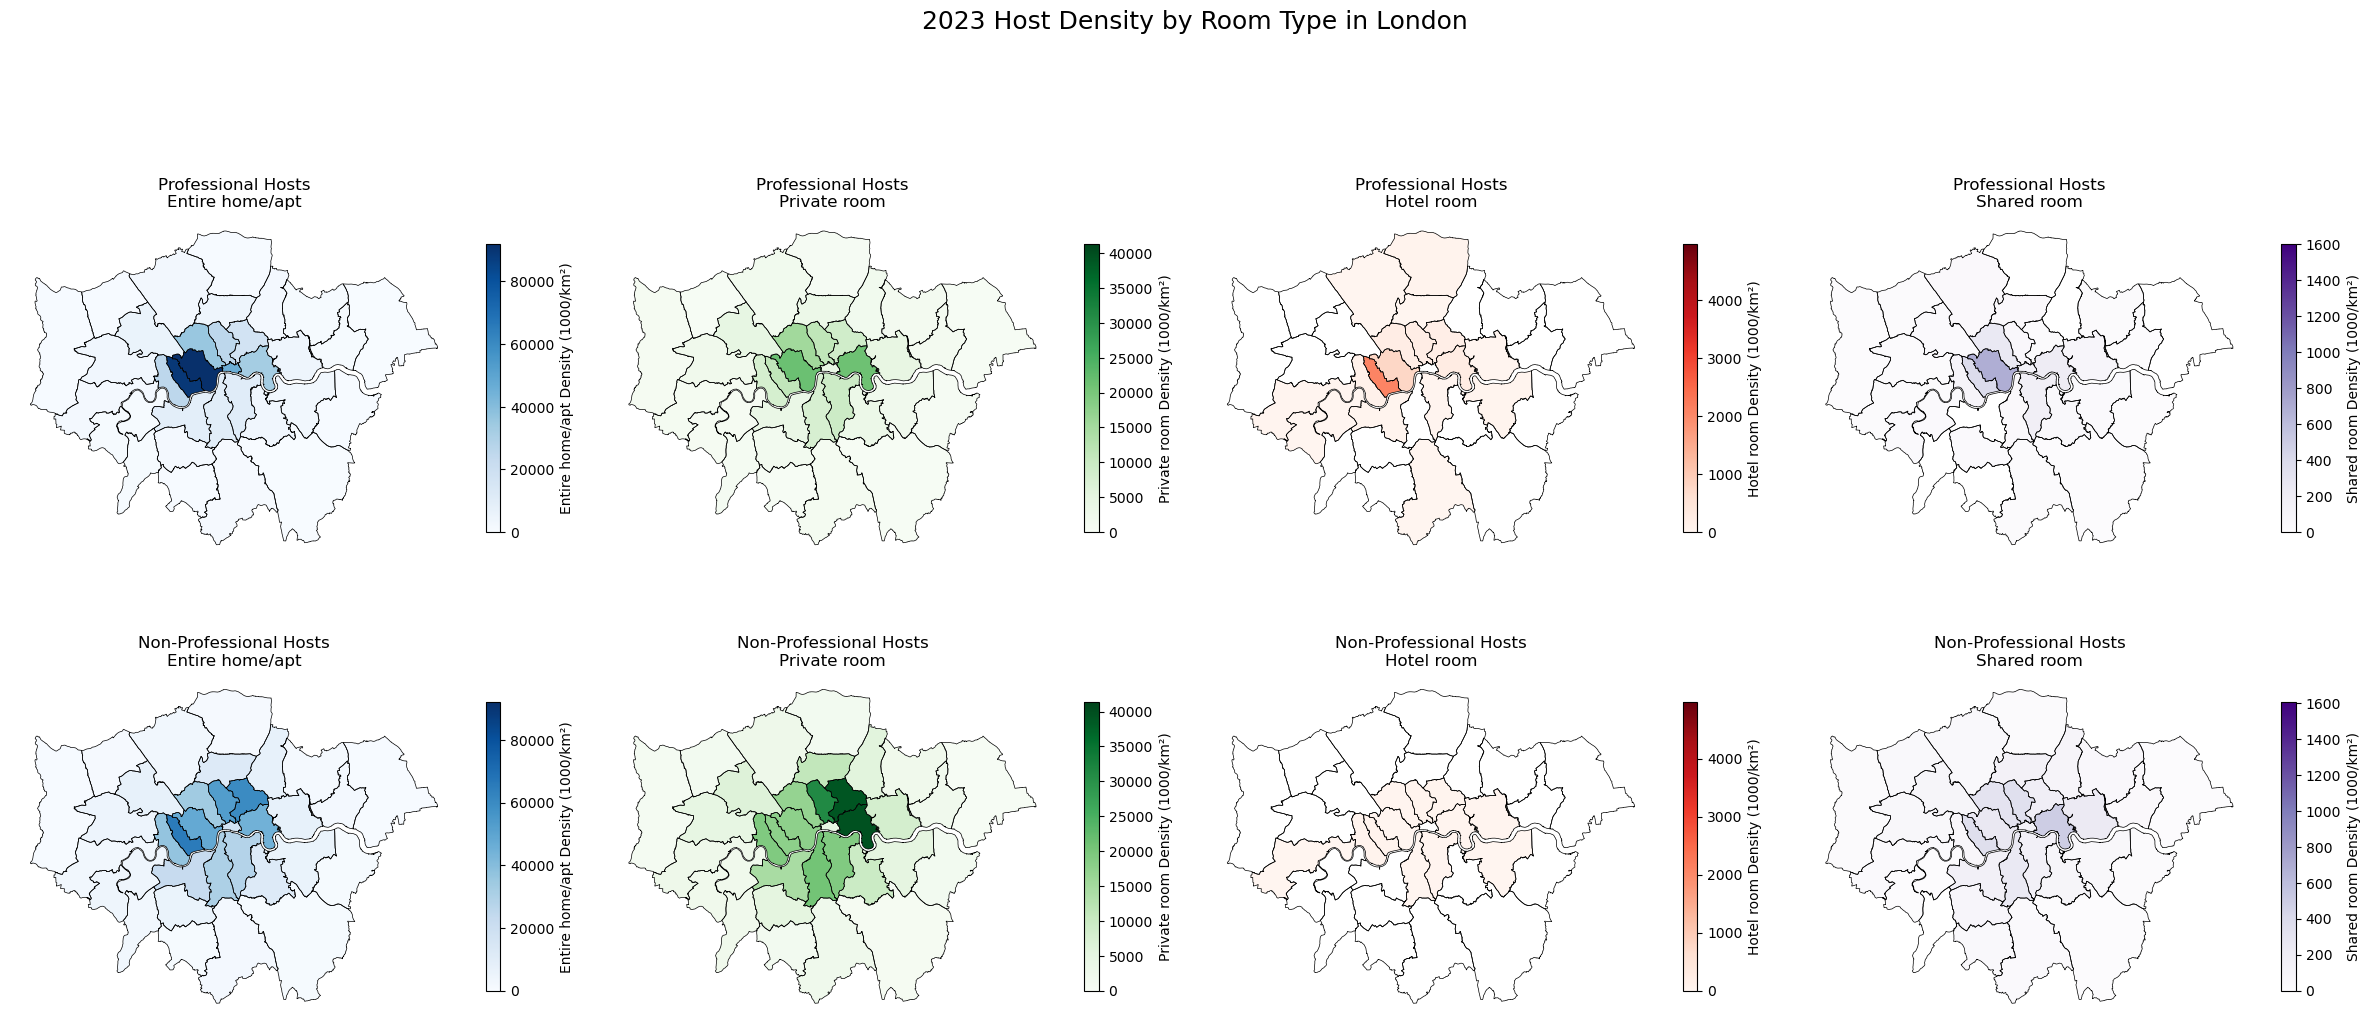

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 加载数据文件
file_paths = {
    "2019": "cleaned_2019_data.csv",
    "2021": "cleaned_2021_data.csv",
    "2023": "cleaned_2023_data.csv",
}
dataframes = []

# 加载数据并添加年份列
for year, path in file_paths.items():
    df = pd.read_csv(path)
    df['year'] = year
    dataframes.append(df)

# 合并所有年份的数据
combined_data = pd.concat(dataframes, ignore_index=True)

# 加载行政区 shapefile
boroughs = gpd.read_file("London_Borough_Excluding_MHW.shp").to_crs("EPSG:4326")
boroughs['area_km2'] = boroughs['geometry'].to_crs(epsg=3395).area / 1e6

# 筛选必要列
columns_needed = ['year', 'host_id', 'calculated_host_listings_count', 'neighbourhood_cleansed', 'room_type']
host_data = combined_data[columns_needed].dropna()

# 添加房东类型列
host_data['host_type'] = host_data['calculated_host_listings_count'].apply(
    lambda x: "Non-professional" if x <= 2 else "Professional"
)

# 按年份、区域、房东类型和房源类型计算密度
host_counts = host_data.groupby(
    ['year', 'neighbourhood_cleansed', 'room_type', 'host_type']
).size().reset_index(name='count')
host_counts = host_counts.merge(
    boroughs[['NAME', 'area_km2']],
    left_on='neighbourhood_cleansed',
    right_on='NAME',
    how='left'
)
host_counts['density'] = (host_counts['count'] / host_counts['area_km2']) * 1000

# 转换为 GeoDataFrame
boroughs = boroughs.rename(columns={"NAME": "borough"})
data_geo = pd.merge(boroughs, host_counts, how="left", left_on="borough", right_on="neighbourhood_cleansed")

# 获取房源类型和年份
room_types = host_data['room_type'].unique()
years = host_data['year'].unique()

# 计算每种房型在所有年份的密度范围
density_ranges = {
    room_type: data_geo[data_geo['room_type'] == room_type]['density'].max()
    for room_type in room_types
}

# 绘图函数
def plot_yearly_density(data_geo, year, room_types, title, output_file, density_ranges, boroughs):
    fig, axes = plt.subplots(2, len(room_types), figsize=(len(room_types) * 6, 12))
    colormaps = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges']

    year_data = data_geo[data_geo['year'] == year]
    professional_data = year_data[year_data['host_type'] == 'Professional']
    non_professional_data = year_data[year_data['host_type'] == 'Non-professional']

    for i, room_type in enumerate(room_types):
        cmap = colormaps[i % len(colormaps)]

        # 专业房东（上行）
        ax1 = axes[0, i]
        subset1 = professional_data[professional_data['room_type'] == room_type]
        boroughs.boundary.plot(ax=ax1, color="black", linewidth=0.5)
        subset1.plot(
            column='density',
            cmap=cmap,
            legend=True,
            legend_kwds={'label': f"{room_type} Density (1000/km²)", 'shrink': 0.5},
            ax=ax1,
            vmin=0,
            vmax=density_ranges[room_type],
            missing_kwds={"color": "lightgrey", "label": "No data"}
        )
        ax1.set_title(f"Professional Hosts\n{room_type}", fontsize=12)
        ax1.axis('off')

        # 非专业房东（下行）
        ax2 = axes[1, i]
        subset2 = non_professional_data[non_professional_data['room_type'] == room_type]
        boroughs.boundary.plot(ax=ax2, color="black", linewidth=0.5)
        subset2.plot(
            column='density',
            cmap=cmap,
            legend=True,
            legend_kwds={'label': f"{room_type} Density (1000/km²)", 'shrink': 0.5},
            ax=ax2,
            vmin=0,
            vmax=density_ranges[room_type],
            missing_kwds={"color": "lightgrey", "label": "No data"}
        )
        ax2.set_title(f"Non-Professional Hosts\n{room_type}", fontsize=12)
        ax2.axis('off')

    # 设置总体标题
    plt.suptitle(title, fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(output_file, dpi=300)
    plt.show()

# 调用函数分别绘制每年的图像
for year in years:
    plot_yearly_density(
        data_geo,
        year,
        room_types,
        f"{year} Host Density by Room Type in London",
        f"host_density_{year}.png",
        density_ranges,
        boroughs
    )
